In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
from math import sqrt

In [ ]:
import yfinance
ticker = "ASII.JK"
start_date = "2010-01-01"
end_date = "2024-05-22"
# end_date = datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3530.0,3550.0,3465.0,3530.0,2001.564819,40
2010-01-05,3550.0,3570.0,3485.0,3550.0,2012.905029,40
2010-01-06,3530.0,3580.0,3515.0,3530.0,2001.564819,40
2010-01-07,3420.0,3560.0,3415.0,3420.0,1939.193481,40
2010-01-08,3440.0,3450.0,3380.0,3440.0,1950.533325,40


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,4570.0,4620.0,4530.0,4530.0,4530.0,109962400
2024-05-16,4590.0,4720.0,4540.0,4710.0,4710.0,149039700
2024-05-17,4710.0,4810.0,4690.0,4800.0,4800.0,101492400
2024-05-20,4800.0,4830.0,4730.0,4740.0,4740.0,58021800
2024-05-21,4750.0,4770.0,4700.0,4700.0,4700.0,57558000


In [ ]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3549.000000,3549.000000,3549.000000,3549.000000,3549.000000,3.549000e+03
mean,6611.886447,6687.533108,6528.150183,6606.948436,4637.549026,3.774913e+07
std,1159.194883,1162.137147,1155.418791,1159.974682,904.459227,2.641502e+07
min,3220.000000,3365.000000,3220.000000,3280.000000,1893.831787,0.000000e+00
25%,5775.000000,5850.000000,5700.000000,5760.000000,4154.338379,2.241840e+07
50%,6750.000000,6825.000000,6650.000000,6750.000000,4712.519531,3.200630e+07
75%,7450.000000,7500.000000,7350.000000,7450.000000,5280.907227,4.648780e+07
max,9250.000000,9350.000000,8975.000000,9150.000000,6416.824707,3.114024e+08


In [ ]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
print("Kolom Yang tersedia dalam data saham yang tersedia: ", data.columns.tolist())
column_to_predict = input("Masukan kolom yang ingin di prediksi (contoh :, 'Close' tanpa tanda kutip) : ")

if column_to_predict not in data.columns:
    raise ValueError(f"Column '{column_to_predict}' Tidak ada. Columns yang tersedia: {data.columns.tolist()}")


Kolom Yang tersedia dalam data saham yang tersedia:  ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Masukan kolom yang ingin di prediksi (contoh :, 'Close' tanpa tanda kutip) : Close


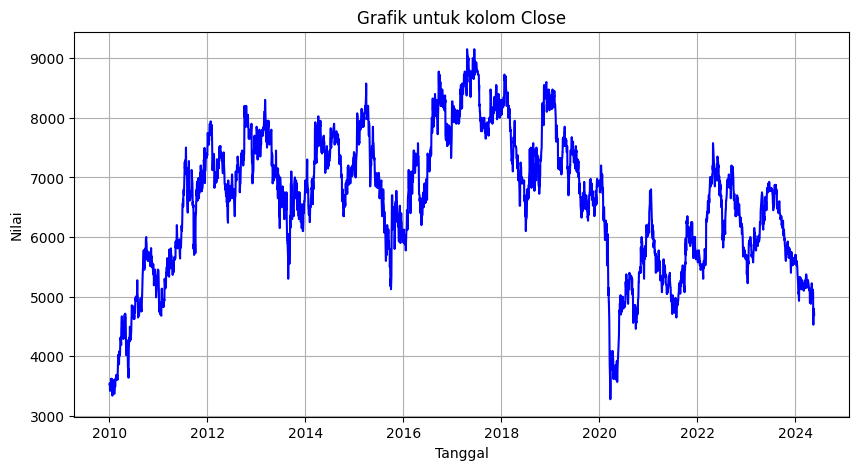

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, data[column_to_predict], marker='', linestyle='-', color='b')
plt.title(f'Grafik untuk kolom {column_to_predict}')
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.grid(True)
plt.show()

In [ ]:
data_to_use = data[column_to_predict].values.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_to_use)

In [ ]:
print(data[column_to_predict][:5])

Date
2010-01-04    3530.0
2010-01-05    3550.0
2010-01-06    3530.0
2010-01-07    3420.0
2010-01-08    3440.0
Name: Close, dtype: float64


In [ ]:
print(data_scaled[:5])

[[0.04258944]
 [0.04599659]
 [0.04258944]
 [0.02385009]
 [0.02725724]]


#Pembagian data latih dan data uji

In [ ]:
training_size = int(len(data_scaled)*0.80)
test_size=len(data_scaled)-training_size
train_data,test_data=data_scaled[0:training_size,:],data_scaled[training_size:len(data_scaled),:1]
training_size,test_size

(2839, 710)

# Pembuatan data sekuensial

In [ ]:
time_step = 90
X_train, y_train = [], []
for i in range(len(train_data) - time_step - 1):
    a = train_data[i:(i + time_step), 0]
    X_train.append(a)
    y_train.append(train_data[i + time_step, 0])

X_test, y_test = [], []
for i in range(len(test_data) - time_step - 1):
    a = test_data[i:(i + time_step), 0]
    X_test.append(a)
    y_test.append(test_data[i + time_step, 0])

X_train = np.array(X_train).reshape(-1, time_step, 1)
X_test = np.array(X_test).reshape(-1, time_step, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
X_train.shape[1],1

(90, 1)

In [ ]:
# from keras.layers import LSTM, Dropout, Dense
# from keras.models import Sequential

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0))
# model.add(Dropout(0.4))
# model.add(LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0))
# model.add(Dropout(0.4))
# model.add(LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0))
# model.add(Dropout(0.4))
# model.add(LSTM(64, return_sequences=False, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.summary()


In [ ]:
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_percentage_error', 'mean_squared_error'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 90, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 90, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 90, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 64)            49408     
                                                                 
 dropout_2 (Dropout)         (None, 90, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)

Epoch 1/100
35/35 [==============================] - 13s 67ms/step - loss: 0.0475 - mean_absolute_percentage_error: 25.7696 - mean_squared_error: 0.0475 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 803014.3125 - val_mean_squared_error: 0.0091
Epoch 2/100
 7/35 [=====>........................] - ETA: 0s - loss: 0.0105 - mean_absolute_percentage_error: 15.0294 - mean_squared_error: 0.0105

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 1s 31ms/step - loss: 0.0069 - mean_absolute_percentage_error: 11.8972 - mean_squared_error: 0.0069 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 720597.8125 - val_mean_squared_error: 0.0057
Epoch 3/100
35/35 [==============================] - 2s 48ms/step - loss: 0.0048 - mean_absolute_percentage_error: 9.4501 - mean_squared_error: 0.0048 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 702184.8125 - val_mean_squared_error: 0.0058
Epoch 4/100
35/35 [==============================] - 1s 32ms/step - loss: 0.0047 - mean_absolute_percentage_error: 9.2801 - mean_squared_error: 0.0047 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 730885.9375 - val_mean_squared_error: 0.0074
Epoch 5/100
35/35 [==============================] - 1s 22ms/step - loss: 0.0044 - mean_absolute_percentage_error: 9.0028 - mean_squared_error: 0.0044 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 664321.3750 - val_mean_squared_error: 0.0049

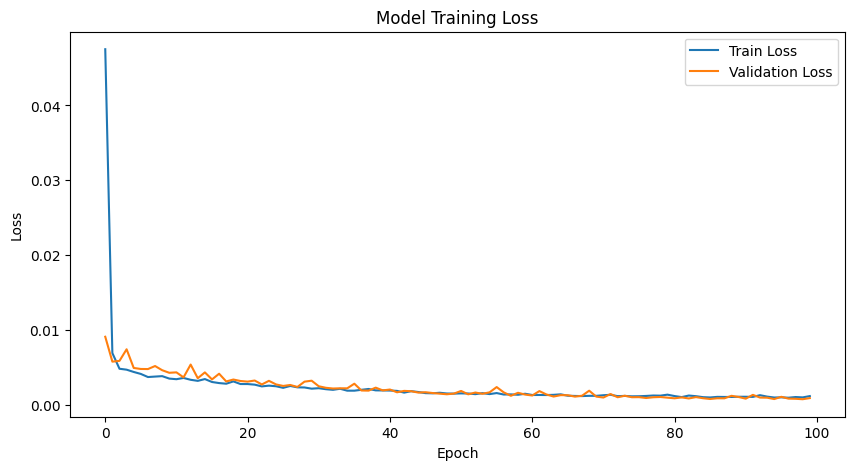

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

20/20 [==============================] - 1s 12ms/step


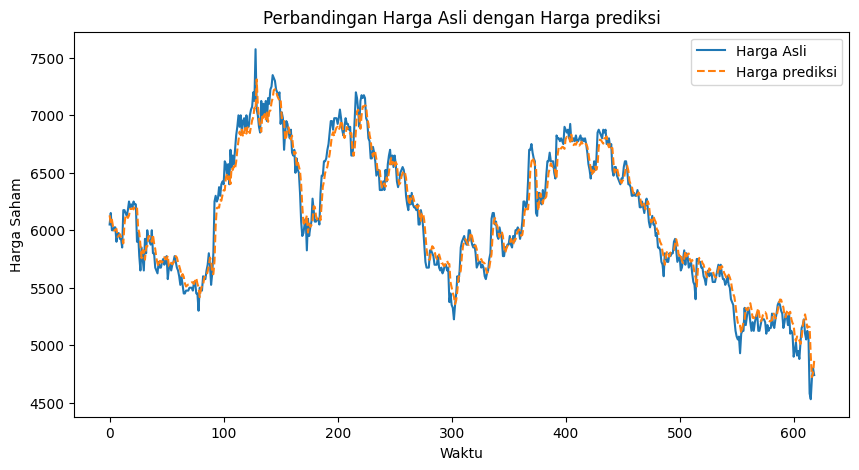

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np


y_pred = model.predict(X_test)

y_pred_denorm = scaler.inverse_transform(y_pred)
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

dates = pd.date_range(start=start_date, periods=len(data), freq='B')
plt.figure(figsize=(10, 5))
plt.plot(y_test_denorm, label='Harga Asli')
plt.plot(y_pred_denorm, label='Harga prediksi', linestyle='--')
plt.title('Perbandingan Harga Asli dengan Harga prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_denorm = scaler.inverse_transform(train_predict)
test_predict_denorm = scaler.inverse_transform(test_predict)

y_train_denorm = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))


20/20 [==============================] - 0s 7ms/step


In [ ]:
# dates = pd.date_range(start=start_date, periods=len(data), freq='B')

# full_actual = np.concatenate((y_train_denorm, y_test_denorm), axis=0)
# full_predicted = np.concatenate((train_predict_denorm, test_predict_denorm), axis=0)
# adjusted_dates = dates[:len(full_actual)]
# plt.figure(figsize=(15, 8))
# plt.plot(adjusted_dates, full_actual, label='Actual Data')
# plt.plot(adjusted_dates[:len(y_train_denorm)], train_predict_denorm, linestyle='--', label='Train Predictions')
# plt.plot(adjusted_dates[len(y_train_denorm):], test_predict_denorm, linestyle='--', label='Test Predictions')
# plt.title('Comparison of Actual and Predicted Values')
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.gcf().autofmt_xdate()
# plt.show()


In [ ]:
y_pred = model.predict(X_test)

# Denormalize the predictions and actual values
y_pred_denorm = scaler.inverse_transform(y_pred)
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Generate dates for x-axis
test_dates = pd.date_range(start=data.index[training_size + time_step], periods=len(y_test), freq='B')

20/20 [==============================] - 0s 7ms/step


In [ ]:
print(y_test_denorm[:5])

[[6050.]
 [6150.]
 [6000.]
 [6000.]
 [6025.]]


In [ ]:
print(y_pred_denorm[:5])
print()

[[6129.795 ]
 [6062.288 ]
 [6092.0396]
 [6031.1416]
 [5996.4595]]



In [ ]:
df_results = pd.DataFrame({
    'Tahun': test_dates,
    'Data_Close_Asli': y_test_denorm.flatten(),
    'Data_Close_Prediksi': y_pred_denorm.flatten()
})

print(df_results.head())

       Tahun  Data_Close_Asli  Data_Close_Prediksi
0 2021-10-25           6050.0          6129.794922
1 2021-10-26           6150.0          6062.288086
2 2021-10-27           6000.0          6092.039551
3 2021-10-28           6000.0          6031.141602
4 2021-10-29           6025.0          5996.459473


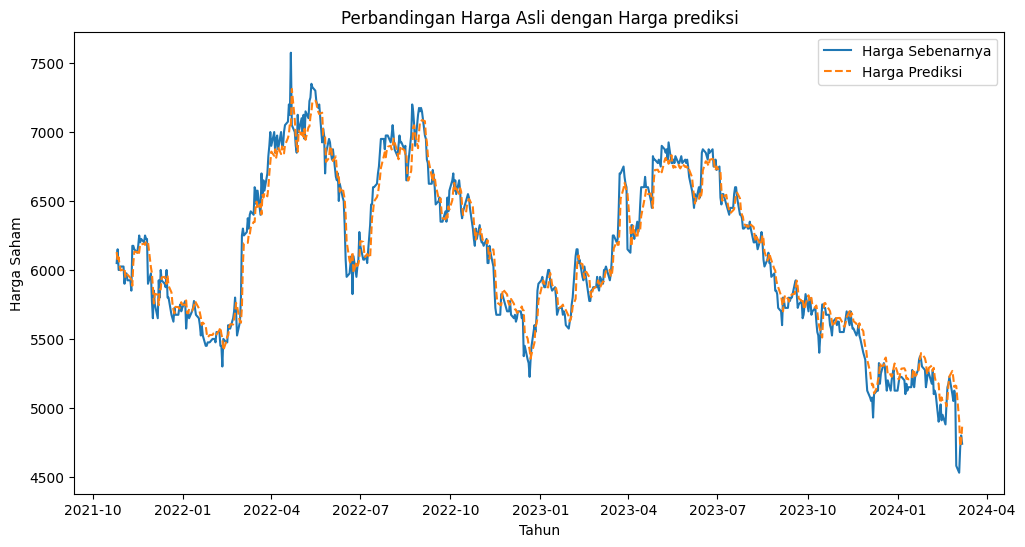

In [ ]:
test_dates = pd.date_range(start=data.index[training_size + time_step], periods=len(y_test), freq='B')
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_denorm, label='Harga Sebenarnya')
plt.plot(test_dates, y_pred_denorm, label='Harga Prediksi', linestyle='--')
plt.title('Perbandingan Harga Asli dengan Harga prediksi')
plt.xlabel('Tahun')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

In [ ]:
mean_y_test = np.mean(y_test_denorm)


In [ ]:
mae = np.mean(np.abs(y_test_denorm - y_pred_denorm))
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
# Persentase MAE
mae_percentage = (mae / mean_y_test) * 100
print("Persentase MAE: {:.2f}%".format(mae_percentage))


Mean Absolute Error (MAE): 87.69
Persentase MAE: 1.44%


In [ ]:
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test_denorm - y_pred_denorm) ** 2))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
rmse_percentage = (rmse / mean_y_test) * 100
print("Persentase RMSE: {:.2f}%".format(rmse_percentage))


Root Mean Squared Error (RMSE): 116.87
Persentase RMSE: 1.92%


In [ ]:
# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / y_test_denorm)) * 100
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Mean Absolute Percentage Error (MAPE): 1.45%


In [ ]:
# Mean Absolute Error


# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test_denorm - y_pred_denorm) ** 2))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))


# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / y_test_denorm)) * 100
print("Mean Absolute Percentage Error (MAPE): {:.2f} %".format(mape))


# Persentase MAE
mae_percentage = (mae / mean_y_test) * 100
print("Persentase MAE:", mae_percentage, "%")

rmse_percentage = (rmse / mean_y_test) * 100
print("Persenatase RMSE:", rmse_percentage, "%")

Root Mean Squared Error (RMSE): 116.87
Mean Absolute Percentage Error (MAPE): 1.45 %
Persentase MAE: 1.4376012468614094 %
Persenatase RMSE: 1.9159983129268994 %
